# Reconstructing LMRv2.1 with cfr

In [9]:
%load_ext autoreload
%autoreload 2

import cfr
import numpy as np
print(cfr.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024.11.6


## Load Data

### Load proxies

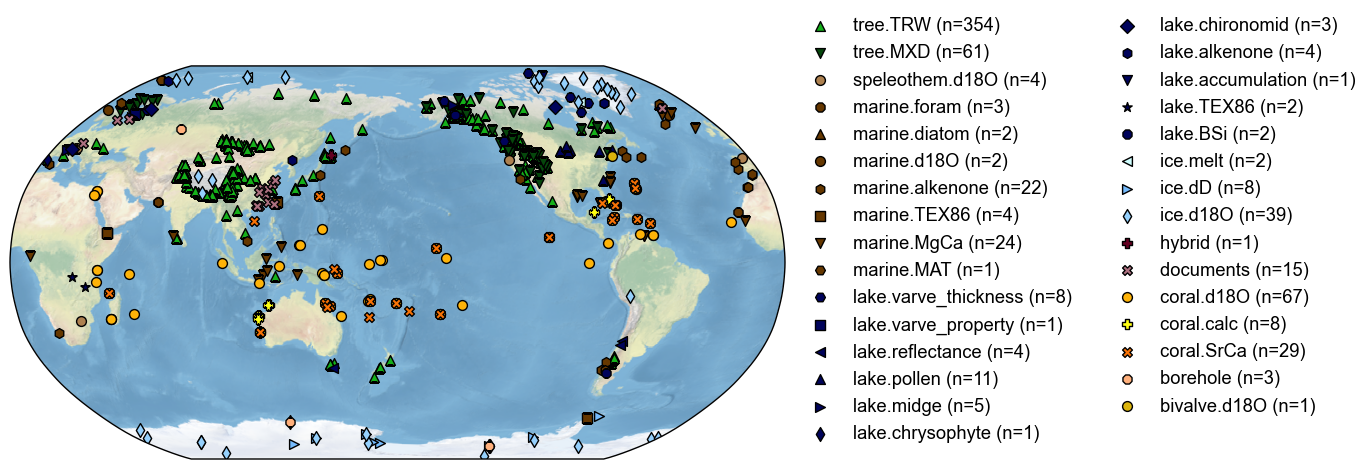

In [10]:
job = cfr.ReconJob()
job.load_proxydb('PAGES2kv2')

fig, ax = job.proxydb.plot() # plot to check

### Load model prior (CMIP5 CCSM4 last1000 simulated tas and pr fields)

In [11]:
job.load_clim(
    tag='prior',
    
    path_dict= {
    'tas': './LMR_data/data/model/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc',
    'pr': './LMR_data/data/model/ccsm4_last_millenium/pr_sfc_Amon_CCSM4_past1000_085001-185012.nc'
    },
    anom_period=[850,1850],  # calculate anomalies against the entire interval
    load=True,  
    verbose=True,
)

>>> job.configs["prior_path"] = {'tas': './LMR_data/data/model/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc', 'pr': './LMR_data/data/model/ccsm4_last_millenium/pr_sfc_Amon_CCSM4_past1000_085001-185012.nc'}
>>> job.configs["prior_anom_period"] = [850, 1850]
>>> job.configs["prior_lat_name"] = lat
>>> job.configs["prior_lon_name"] = lon
>>> job.configs["prior_time_name"] = time
>>> The time axis does not overlap with the reference period [850, 1850]; use its own time period as reference [.2f, .2f].
>>> The time axis does not overlap with the reference period [850, 1850]; use its own time period as reference [.2f, .2f].
>>> prior variables ['tas', 'pr'] loaded
>>> job.prior created


In [12]:
# Check after load
print("\nAfter initial load:")
print("Shape:", job.prior['tas'].da.shape)
print("Contains NaN?", np.any(np.isnan(job.prior['tas'].da.values)))
if not np.any(np.isnan(job.prior['tas'].da.values)):
    print("Sample values from first timestep:")
    vals = job.prior['tas'].da.isel(time=0, lat=slice(0,5), lon=slice(0,5)).values
    print(vals)


After initial load:
Shape: (12012, 192, 288)
Contains NaN? False
Sample values from first timestep:
[[ 4.2724609e-04 -1.4116669e+00 -1.4149780e+00 -7.6078796e-01
  -1.3295441e+00]
 [ 2.8004456e-01  2.4789429e-01  3.3767700e-01 -5.2047729e-02
   3.3233643e-01]
 [ 4.6669006e-01 -1.6618347e-01  5.8181763e-01 -2.5801086e-01
   2.7944946e-01]
 [ 3.3268738e-01  3.2659912e-01  3.8771057e-01  4.2834473e-01
   6.8528748e-01]
 [ 3.4626770e-01  3.5942078e-01  6.5942383e-01  1.0366669e+00
   7.7363586e-01]]


### Load instrumental observations

In [13]:
job.load_clim(
    tag='obs',
    path_dict={
        'pr': 'GPCCv2020',
        'tas': 'gistemp1200_ERSSTv4'
    },
    rename_dict={'pr': 'precip','tas': 'tempanomaly'},
    anom_period=[1951, 1980], # this may have to change
    load=True,
)

>>> The target file seems existed at: ./data/precip.monitor.mon.total.1x1.v2020.nc . Loading from it instead of downloading ...
>>> The target file seems existed at: ./data/precip.monitor.mon.total.1x1.v2020.nc . Loading from it instead of downloading ...
>>> The target file seems existed at: ./data/gistemp1200_ERSSTv4.nc.gz . Loading from it instead of downloading ...


## Calibrate PSM

In [14]:
# PSM to be used
ptype_psm_dict = {
    'tree.TRW': 'Bilinear',
    'tree.MXD': 'Linear',
    'coral.d18O': 'Linear',
    'coral.SrCa': 'Linear',
    'ice.d18O': 'Linear',
    'lake.varve_thickness': 'Linear',
}

# target variables
ptype_clim_dict = {
    'tree.TRW': ['tas', 'pr'],
    'tree.MXD': ['tas'],
    'coral.d18O': ['tas'],
    'coral.SrCa': ['tas'],
    'ice.d18O': ['tas'],
    'lake.varve_thickness': ['tas'],
}

# Seasonality for each proxy type
ptype_season_dict = {
    'tree.TRW': [  # expert curated pool of possible growing seasons
        [1,2,3,4,5,6,7,8,9,10,11,12],
        [6,7,8],
        [3,4,5,6,7,8],
        [6,7,8,9,10,11],
        [-12,1,2],
        [-9,-10,-11,-12,1,2],
        [-12,1,2,3,4,5],
    ],
    'tree.MXD': [  # expert curated pool of possible growing seasons
        #[1,2,3,4,5,6,7,8,9,10,11,12],
        [6,7,8],
        [3,4,5,6,7,8],
        [6,7,8,9,10,11],
        [-12,1,2],
        [-9,-10,-11,-12,1,2],
        [-12,1,2,3,4,5],
    ],
    'coral.d18O': list(range(1, 13)),            # annual
    'coral.SrCa': list(range(1, 13)),            # annual
    'ice.d18O': list(range(1, 13)),              # annual
    'lake.varve_thickness': list(range(1, 13)),  # annual
}

In [16]:
job.calib_psms(
    ptype_psm_dict=ptype_psm_dict,
    ptype_season_dict=ptype_season_dict,
    ptype_clim_dict=ptype_clim_dict,
    nobs_lb = 25,
    verbose=True,
)

>>> job.configs["ptype_psm_dict"] = {'lake.midge': 'Linear', 'coral.SrCa': 'Linear', 'marine.MgCa': 'Linear', 'lake.BSi': 'Linear', 'speleothem.d18O': 'Linear', 'ice.melt': 'Linear', 'marine.TEX86': 'Linear', 'tree.MXD': 'Linear', 'bivalve.d18O': 'Linear', 'lake.chrysophyte': 'Linear', 'hybrid': 'Linear', 'documents': 'Linear', 'ice.dD': 'Linear', 'marine.diatom': 'Linear', 'marine.d18O': 'Linear', 'tree.TRW': 'Bilinear', 'lake.TEX86': 'Linear', 'borehole': 'Linear', 'marine.foram': 'Linear', 'ice.d18O': 'Linear', 'lake.varve_property': 'Linear', 'marine.MAT': 'Linear', 'coral.d18O': 'Linear', 'coral.calc': 'Linear', 'lake.accumulation': 'Linear', 'lake.reflectance': 'Linear', 'lake.varve_thickness': 'Linear', 'lake.chironomid': 'Linear', 'lake.pollen': 'Linear', 'marine.alkenone': 'Linear', 'lake.alkenone': 'Linear'}
>>> job.configs["ptype_season_dict"] = {'lake.midge': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'coral.SrCa': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'marine.MgCa': [1, 2

Calibrating the PSMs:   0%|          | 0/692 [00:00<?, ?it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   0%|          | 1/692 [00:00<10:32,  1.09it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 9 < 25. Skipping ...


Calibrating the PSMs:   0%|          | 3/692 [00:01<03:45,  3.06it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   1%|          | 4/692 [00:02<06:27,  1.77it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   1%|          | 5/692 [00:03<08:13,  1.39it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   1%|          | 7/692 [00:04<07:04,  1.62it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   1%|          | 8/692 [00:05<07:48,  1.46it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:   2%|▏         | 11/692 [00:05<04:25,  2.57it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   2%|▏         | 12/692 [00:06<06:04,  1.87it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 7 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   2%|▏         | 15/692 [00:07<04:46,  2.36it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   2%|▏         | 17/692 [00:08<04:55,  2.29it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   3%|▎         | 18/692 [00:09<06:04,  1.85it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   3%|▎         | 19/692 [00:10<07:07,  1.57it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:   3%|▎         | 20/692 [00:10<06:10,  1.82it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   3%|▎         | 21/692 [00:11<07:46,  1.44it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   3%|▎         | 23/692 [00:12<07:07,  1.56it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   3%|▎         | 24/692 [00:13<07:47,  1.43it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   4%|▎         | 25/692 [00:14<08:14,  1.35it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   4%|▍         | 27/692 [00:15<06:51,  1.62it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   4%|▍         | 28/692 [00:16<07:27,  1.48it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   4%|▍         | 29/692 [00:17<08:10,  1.35it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 1 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   5%|▍         | 32/692 [00:18<05:54,  1.86it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 9 < 25. Skipping ...
The number of overlapped data points is 15 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlappe

Calibrating the PSMs:   5%|▌         | 35/692 [00:19<04:52,  2.25it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   5%|▌         | 37/692 [00:20<05:00,  2.18it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   5%|▌         | 38/692 [00:21<05:42,  1.91it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   6%|▌         | 39/692 [00:22<06:36,  1.65it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   6%|▌         | 40/692 [00:23<07:32,  1.44it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   6%|▌         | 41/692 [00:24<08:14,  1.32it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 9 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   6%|▋         | 44/692 [00:25<05:56,  1.82it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   7%|▋         | 45/692 [00:26<06:50,  1.57it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   7%|▋         | 46/692 [00:27<07:39,  1.41it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   7%|▋         | 47/692 [00:28<08:15,  1.30it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   7%|▋         | 48/692 [00:28<08:29,  1.26it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   7%|▋         | 50/692 [00:29<06:54,  1.55it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:   7%|▋         | 51/692 [00:30<05:47,  1.85it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   8%|▊         | 54/692 [00:30<04:32,  2.34it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   8%|▊         | 57/692 [00:31<03:59,  2.65it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   9%|▊         | 59/692 [00:32<04:20,  2.43it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   9%|▊         | 60/692 [00:33<05:24,  1.95it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:   9%|▉         | 61/692 [00:34<06:17,  1.67it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:   9%|▉         | 64/692 [00:34<03:34,  2.92it/s]

The number of overlapped data points is 12 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlappe

Calibrating the PSMs:  10%|▉         | 66/692 [00:35<04:03,  2.57it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  10%|▉         | 67/692 [00:36<03:42,  2.81it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  10%|▉         | 68/692 [00:37<04:58,  2.09it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  10%|█         | 70/692 [00:38<05:02,  2.05it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  10%|█         | 71/692 [00:39<05:57,  1.74it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  10%|█         | 72/692 [00:39<06:42,  1.54it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  11%|█         | 73/692 [00:40<07:18,  1.41it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 12 < 25. Skipping ...
The number of overlappe

Calibrating the PSMs:  11%|█         | 76/692 [00:41<05:14,  1.96it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  11%|█         | 77/692 [00:42<06:00,  1.70it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  11%|█▏        | 79/692 [00:43<05:32,  1.84it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  12%|█▏        | 81/692 [00:44<05:15,  1.94it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  12%|█▏        | 82/692 [00:45<05:59,  1.70it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 1 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  12%|█▏        | 84/692 [00:46<05:34,  1.82it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  12%|█▏        | 85/692 [00:47<06:15,  1.61it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  12%|█▏        | 86/692 [00:48<06:53,  1.47it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  13%|█▎        | 87/692 [00:49<07:29,  1.34it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  13%|█▎        | 88/692 [00:49<07:53,  1.28it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  13%|█▎        | 89/692 [00:50<06:18,  1.59it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 11 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlappe

Calibrating the PSMs:  13%|█▎        | 92/692 [00:51<04:37,  2.16it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  13%|█▎        | 93/692 [00:51<04:06,  2.43it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  14%|█▎        | 95/692 [00:52<04:17,  2.32it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  14%|█▍        | 96/692 [00:53<05:14,  1.90it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  14%|█▍        | 99/692 [00:54<04:17,  2.30it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  14%|█▍        | 100/692 [00:55<05:07,  1.93it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  15%|█▍        | 102/692 [00:56<04:54,  2.00it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 14 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlappe

Calibrating the PSMs:  15%|█▌        | 105/692 [00:56<04:10,  2.35it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  15%|█▌        | 106/692 [00:57<04:55,  1.98it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  15%|█▌        | 107/692 [00:58<05:40,  1.72it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  16%|█▌        | 112/692 [00:59<03:20,  2.90it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  16%|█▋        | 113/692 [01:00<04:13,  2.28it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  17%|█▋        | 115/692 [01:01<04:20,  2.21it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  17%|█▋        | 118/692 [01:02<03:53,  2.46it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  17%|█▋        | 119/692 [01:03<04:51,  1.96it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  17%|█▋        | 120/692 [01:04<05:40,  1.68it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 20 < 25. Skipping ...
The number of overlapped data points is 22 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapp

Calibrating the PSMs:  18%|█▊        | 123/692 [01:05<04:22,  2.17it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  18%|█▊        | 126/692 [01:06<03:47,  2.49it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 1 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  18%|█▊        | 128/692 [01:07<03:56,  2.39it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 1 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  19%|█▉        | 133/692 [01:08<02:44,  3.39it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 3 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  20%|█▉        | 135/692 [01:09<03:12,  2.89it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  20%|█▉        | 136/692 [01:10<04:02,  2.30it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  20%|██        | 139/692 [01:11<03:35,  2.57it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  20%|██        | 140/692 [01:12<04:21,  2.11it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  21%|██        | 143/692 [01:13<03:45,  2.44it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  21%|██        | 144/692 [01:14<04:28,  2.04it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  21%|██        | 145/692 [01:15<05:09,  1.77it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  21%|██        | 146/692 [01:16<05:47,  1.57it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  21%|██▏       | 148/692 [01:17<05:22,  1.69it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  22%|██▏       | 149/692 [01:18<05:56,  1.52it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 8 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  22%|██▏       | 151/692 [01:19<05:15,  1.72it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 8 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  22%|██▏       | 153/692 [01:19<04:51,  1.85it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  23%|██▎       | 156/692 [01:20<03:58,  2.25it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  23%|██▎       | 160/692 [01:21<02:47,  3.17it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  23%|██▎       | 162/692 [01:23<04:13,  2.09it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  24%|██▎       | 163/692 [01:24<04:50,  1.82it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  24%|██▍       | 165/692 [01:25<04:36,  1.90it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  24%|██▍       | 166/692 [01:26<05:12,  1.68it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  24%|██▍       | 167/692 [01:27<05:47,  1.51it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  24%|██▍       | 168/692 [01:28<06:14,  1.40it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 9 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  25%|██▌       | 173/692 [01:29<02:59,  2.89it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 4 < 25. Skipping ...
The number of overlapped data points is 24 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlappe

Calibrating the PSMs:  26%|██▌       | 177/692 [01:30<02:34,  3.34it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  26%|██▌       | 178/692 [01:30<02:26,  3.51it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  26%|██▌       | 179/692 [01:31<03:20,  2.56it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  26%|██▋       | 183/692 [01:31<01:48,  4.71it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  27%|██▋       | 185/692 [01:33<03:32,  2.39it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  27%|██▋       | 188/692 [01:33<02:26,  3.45it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  27%|██▋       | 189/692 [01:34<03:14,  2.59it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  27%|██▋       | 190/692 [01:35<04:01,  2.08it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  28%|██▊       | 194/692 [01:36<02:36,  3.17it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 9 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  28%|██▊       | 197/692 [01:37<02:55,  2.83it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  29%|██▊       | 198/692 [01:38<04:18,  1.91it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  29%|██▉       | 199/692 [01:39<05:01,  1.64it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  29%|██▉       | 200/692 [01:40<05:33,  1.48it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  29%|██▉       | 203/692 [01:40<02:50,  2.87it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  30%|██▉       | 205/692 [01:41<03:07,  2.60it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  30%|██▉       | 206/692 [01:42<03:56,  2.06it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  30%|██▉       | 207/692 [01:43<04:38,  1.74it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  30%|███       | 209/692 [01:44<04:17,  1.88it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 21 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlappe

Calibrating the PSMs:  30%|███       | 211/692 [01:45<04:04,  1.97it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  31%|███       | 212/692 [01:46<04:41,  1.71it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  31%|███       | 213/692 [01:46<04:00,  1.99it/s]

The number of overlapped data points is 3 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  31%|███       | 215/692 [01:47<03:56,  2.02it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 6 < 25. Skipping ...
The number of overlapped data points is 6 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  32%|███▏      | 218/692 [01:48<03:16,  2.41it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  32%|███▏      | 219/692 [01:49<03:57,  1.99it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  32%|███▏      | 220/692 [01:50<04:34,  1.72it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  32%|███▏      | 221/692 [01:51<05:08,  1.52it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  32%|███▏      | 222/692 [01:52<05:38,  1.39it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  32%|███▏      | 223/692 [01:53<06:00,  1.30it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  32%|███▏      | 224/692 [01:53<06:16,  1.24it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  33%|███▎      | 228/692 [01:54<03:06,  2.48it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  33%|███▎      | 229/692 [01:55<03:54,  1.97it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  33%|███▎      | 230/692 [01:56<03:22,  2.28it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  33%|███▎      | 231/692 [01:57<04:24,  1.74it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  34%|███▎      | 232/692 [01:57<05:03,  1.52it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  34%|███▍      | 235/692 [01:59<03:45,  2.03it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  34%|███▍      | 236/692 [01:59<04:21,  1.74it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 11 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlappe

Calibrating the PSMs:  35%|███▍      | 239/692 [02:00<03:26,  2.19it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 1 < 25. Skipping ...
The number of overlapped data points is 10 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlappe

Calibrating the PSMs:  35%|███▍      | 242/692 [02:01<03:05,  2.42it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  36%|███▌      | 246/692 [02:02<02:32,  2.93it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  36%|███▌      | 248/692 [02:03<02:44,  2.70it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  36%|███▌      | 249/692 [02:04<02:33,  2.88it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  36%|███▌      | 250/692 [02:04<03:14,  2.27it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 21 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlappe

Calibrating the PSMs:  36%|███▋      | 252/692 [02:05<03:16,  2.24it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  37%|███▋      | 253/692 [02:06<03:52,  1.89it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  37%|███▋      | 255/692 [02:07<03:42,  1.96it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  37%|███▋      | 256/692 [02:08<04:17,  1.69it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 6 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  37%|███▋      | 259/692 [02:09<03:21,  2.14it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  38%|███▊      | 262/692 [02:09<02:06,  3.40it/s]

The number of overlapped data points is 18 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlappe

Calibrating the PSMs:  38%|███▊      | 264/692 [02:11<03:16,  2.18it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 9 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  39%|███▊      | 267/692 [02:12<02:53,  2.45it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  39%|███▉      | 269/692 [02:12<02:21,  3.00it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  39%|███▉      | 271/692 [02:13<02:35,  2.71it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  39%|███▉      | 272/692 [02:13<02:23,  2.92it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  39%|███▉      | 273/692 [02:14<03:06,  2.25it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  40%|███▉      | 275/692 [02:15<03:09,  2.20it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 1 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  40%|████      | 277/692 [02:16<03:08,  2.20it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  40%|████      | 280/692 [02:16<01:55,  3.57it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  41%|████      | 282/692 [02:17<02:16,  3.01it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  41%|████      | 284/692 [02:18<02:30,  2.71it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  41%|████      | 285/692 [02:18<02:19,  2.93it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  41%|████▏     | 286/692 [02:19<03:02,  2.22it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  41%|████▏     | 287/692 [02:20<03:41,  1.83it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  42%|████▏     | 288/692 [02:21<04:13,  1.59it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  42%|████▏     | 289/692 [02:22<04:43,  1.42it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 5 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  42%|████▏     | 292/692 [02:23<03:20,  1.99it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  42%|████▏     | 293/692 [02:23<02:56,  2.26it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  42%|████▏     | 294/692 [02:24<03:33,  1.86it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  43%|████▎     | 296/692 [02:25<03:19,  1.98it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 11 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlappe

Calibrating the PSMs:  43%|████▎     | 300/692 [02:26<02:23,  2.73it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  43%|████▎     | 301/692 [02:27<02:54,  2.24it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 6 < 25. Skipping ...
The number of overlapped data points is 1 < 25. Skipping ...
The number of overlapped data points is 10 < 25. Skipping ...


Calibrating the PSMs:  44%|████▍     | 305/692 [02:27<01:44,  3.71it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  44%|████▍     | 306/692 [02:28<02:18,  2.78it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 9 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  45%|████▍     | 308/692 [02:29<02:31,  2.54it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  45%|████▍     | 311/692 [02:30<02:18,  2.74it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  45%|████▌     | 312/692 [02:31<02:49,  2.24it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  46%|████▌     | 315/692 [02:31<02:28,  2.54it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  46%|████▌     | 316/692 [02:32<02:57,  2.12it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  46%|████▋     | 321/692 [02:33<01:45,  3.52it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  47%|████▋     | 323/692 [02:35<02:44,  2.25it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  47%|████▋     | 324/692 [02:36<03:11,  1.92it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  47%|████▋     | 326/692 [02:37<03:04,  1.99it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  47%|████▋     | 328/692 [02:37<02:24,  2.51it/s]

The number of overlapped data points is 22 < 25. Skipping ...
The number of overlapped data points is 22 < 25. Skipping ...
The number of overlapped data points is 6 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapp

Calibrating the PSMs:  48%|████▊     | 332/692 [02:38<01:53,  3.18it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  48%|████▊     | 334/692 [02:39<02:07,  2.81it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  49%|████▊     | 336/692 [02:40<01:48,  3.27it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  49%|████▊     | 337/692 [02:41<02:35,  2.29it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  49%|████▉     | 338/692 [02:42<03:12,  1.84it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  49%|████▉     | 342/692 [02:43<01:52,  3.11it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 1 < 25. Skipping ...
The number of overlapped data points is 19 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlappe

Calibrating the PSMs:  50%|████▉     | 344/692 [02:43<02:08,  2.71it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 4 < 25. Skipping ...


Calibrating the PSMs:  50%|█████     | 346/692 [02:44<01:40,  3.46it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 16 < 25. Skipping ...
The number of overlapped data points is 3 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlappe

Calibrating the PSMs:  51%|█████     | 350/692 [02:45<01:31,  3.73it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  51%|█████     | 353/692 [02:46<01:37,  3.47it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  51%|█████▏    | 355/692 [02:47<01:53,  2.97it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  52%|█████▏    | 357/692 [02:48<02:05,  2.67it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  52%|█████▏    | 358/692 [02:49<02:33,  2.17it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  52%|█████▏    | 359/692 [02:49<03:00,  1.84it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  52%|█████▏    | 360/692 [02:50<03:23,  1.63it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  52%|█████▏    | 362/692 [02:51<03:03,  1.80it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  52%|█████▏    | 363/692 [02:52<03:25,  1.60it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  53%|█████▎    | 365/692 [02:53<03:04,  1.77it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  53%|█████▎    | 366/692 [02:54<03:27,  1.57it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  53%|█████▎    | 367/692 [02:55<03:46,  1.44it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  53%|█████▎    | 368/692 [02:56<04:01,  1.34it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  53%|█████▎    | 369/692 [02:57<04:15,  1.27it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  54%|█████▎    | 371/692 [02:58<03:30,  1.52it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 1 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  54%|█████▍    | 373/692 [02:59<03:07,  1.70it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  54%|█████▍    | 375/692 [03:00<02:51,  1.84it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  54%|█████▍    | 376/692 [03:00<03:15,  1.62it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  54%|█████▍    | 377/692 [03:01<03:35,  1.46it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  55%|█████▍    | 378/692 [03:02<03:50,  1.36it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 10 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlappe

Calibrating the PSMs:  55%|█████▌    | 381/692 [03:03<02:42,  1.91it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  55%|█████▌    | 382/692 [03:04<03:04,  1.68it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_140 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_140 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_140 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_140 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_140 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  55%|█████▌    | 383/692 [03:07<05:54,  1.15s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  55%|█████▌    | 384/692 [03:07<04:44,  1.08it/s]

NAm_096 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_096 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_096 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_096 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_096 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  56%|█████▌    | 387/692 [03:10<04:17,  1.18it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  56%|█████▌    | 389/692 [03:11<02:53,  1.75it/s]

The number of overlapped data points is 0 < 25. Skipping ...
Asi_051 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_051 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_051 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_051 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_051 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  57%|█████▋    | 392/692 [03:14<03:47,  1.32it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_105 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_105 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_105 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_105 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_105 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  57%|█████▋    | 393/692 [03:17<05:39,  1.13s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Arc_002 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Arc_002 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Arc_002 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Arc_002 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Arc_002 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  57%|█████▋    | 394/692 [03:19<07:21,  1.48s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_219 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_219 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_219 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_219 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_219 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0

Calibrating the PSMs:  57%|█████▋    | 395/692 [03:22<08:51,  1.79s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_077 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_077 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_077 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_077 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_077 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  57%|█████▋    | 396/692 [03:25<10:09,  2.06s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  57%|█████▋    | 397/692 [03:25<07:47,  1.59s/it]

Asi_001 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_001 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_001 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_001 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_001 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  58%|█████▊    | 398/692 [03:28<09:34,  1.95s/it]

The number of overlapped data points is 0 < 25. Skipping ...
NAm_007 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_007 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_007 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_007 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_007 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  58%|█████▊    | 399/692 [03:31<10:49,  2.22s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 3 < 25. Skipping ...
Aus_009 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Aus_009 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Aus_009 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Aus_009 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Aus_009 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  58%|█████▊    | 401/692 [03:34<09:10,  1.89s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 5 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_101 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_101 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_101 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_101 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
A

Calibrating the PSMs:  59%|█████▊    | 405/692 [03:37<05:58,  1.25s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_130 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_130 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_130 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_130 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_130 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  59%|█████▊    | 406/692 [03:40<07:15,  1.52s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_132 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_132 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_132 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_132 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_132 >>> Nearest climate is NaN. Searching around within di

Calibrating the PSMs:  59%|█████▉    | 407/692 [03:43<08:28,  1.78s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_070 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_070 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_070 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_070 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_070 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  59%|█████▉    | 411/692 [03:46<05:00,  1.07s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_136 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_136 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_136 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_136 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_136 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  60%|█████▉    | 412/692 [03:49<06:34,  1.41s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_100 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_100 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_100 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_100 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_100 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  60%|██████    | 417/692 [03:52<03:39,  1.25it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_082 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_082 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_082 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_082 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
N

Calibrating the PSMs:  61%|██████    | 419/692 [03:55<04:27,  1.02it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_163 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_163 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_163 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_163 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_163 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  61%|██████    | 420/692 [03:58<05:52,  1.30s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_013 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_013 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_013 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_013 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_013 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  61%|██████    | 423/692 [04:01<05:14,  1.17s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  62%|██████▏   | 426/692 [04:01<03:18,  1.34it/s]

NAm_003 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_003 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_003 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_003 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_003 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  62%|██████▏   | 428/692 [04:04<04:14,  1.04it/s]

Asi_111 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_111 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_111 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_111 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_111 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  62%|██████▏   | 429/692 [04:07<05:35,  1.28s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 13 < 25. Skipping ...
Asi_002 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
As

Calibrating the PSMs:  62%|██████▏   | 431/692 [04:10<05:48,  1.33s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_220 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_220 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_220 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_220 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_220 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  62%|██████▏   | 432/692 [04:13<07:00,  1.62s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_011 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_011 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_011 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_011 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_011 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  63%|██████▎   | 433/692 [04:15<08:07,  1.88s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  63%|██████▎   | 436/692 [04:16<03:58,  1.07it/s]

Asi_145 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_145 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_145 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_145 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_145 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  63%|██████▎   | 437/692 [04:19<06:11,  1.46s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 3 < 25. Skipping ...
Asi_081 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_081 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_081 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_081 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_081 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0

Calibrating the PSMs:  63%|██████▎   | 439/692 [04:22<06:11,  1.47s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_068 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_068 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_068 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_068 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_068 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  64%|██████▎   | 440/692 [04:25<07:57,  1.89s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 1 < 25. Skipping ...
Asi_229 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_229 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_229 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_229 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_229 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0

Calibrating the PSMs:  64%|██████▍   | 442/692 [04:28<07:06,  1.71s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 1 < 25. Skipping ...
NAm_198 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_198 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_198 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_198 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_198 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  64%|██████▍   | 444/692 [04:31<06:40,  1.61s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  64%|██████▍   | 445/692 [04:31<05:26,  1.32s/it]

NAm_151 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_151 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_151 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_151 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_151 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  64%|██████▍   | 446/692 [04:34<07:02,  1.72s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  65%|██████▍   | 447/692 [04:34<05:29,  1.35s/it]

Asi_035 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_035 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_035 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_035 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_035 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  65%|██████▍   | 448/692 [04:37<07:14,  1.78s/it]

The number of overlapped data points is 0 < 25. Skipping ...
Asi_186 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_186 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_186 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_186 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_186 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  65%|██████▍   | 449/692 [04:41<08:38,  2.13s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_120 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_120 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_120 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_120 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_120 >>> Nearest climate is NaN. Searching around within di

Calibrating the PSMs:  65%|██████▌   | 451/692 [04:44<07:54,  1.97s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  65%|██████▌   | 452/692 [04:44<06:12,  1.55s/it]

NAm_138 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_138 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_138 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_138 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_138 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  66%|██████▌   | 454/692 [04:47<05:44,  1.45s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_166 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_166 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_166 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_166 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_166 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  66%|██████▌   | 458/692 [04:50<03:57,  1.02s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  66%|██████▋   | 459/692 [04:51<03:22,  1.15it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 12 < 25. Skipping ...
Asi_158 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_158 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_158 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_158 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_158 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 

Calibrating the PSMs:  67%|██████▋   | 462/692 [04:54<03:36,  1.06it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_060 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_060 >>> Nearest climate is NaN. Searching around within dist

Calibrating the PSMs:  67%|██████▋   | 463/692 [04:57<05:11,  1.36s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  67%|██████▋   | 464/692 [04:57<04:21,  1.15s/it]

The number of overlapped data points is 0 < 25. Skipping ...
Asi_085 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_085 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_085 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_085 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_085 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  67%|██████▋   | 466/692 [05:00<04:48,  1.28s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_081 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_081 >>> Nearest climate is NaN. Searching around within dist

Calibrating the PSMs:  68%|██████▊   | 468/692 [05:03<05:01,  1.35s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_178 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_178 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_178 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_178 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_178 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  68%|██████▊   | 470/692 [05:06<04:59,  1.35s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_142 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_142 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_142 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_142 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_142 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  68%|██████▊   | 473/692 [05:10<04:20,  1.19s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_083 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_083 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_083 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_083 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_083 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  68%|██████▊   | 474/692 [05:13<05:38,  1.55s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 9 < 25. Skipping ...
NAm_112 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_112 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_112 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_112 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_112 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  69%|██████▉   | 476/692 [05:16<05:29,  1.53s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped

Calibrating the PSMs:  69%|██████▉   | 478/692 [05:19<05:37,  1.58s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 5 < 25. Skipping ...
Eur_008 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Eur

Calibrating the PSMs:  69%|██████▉   | 480/692 [05:22<05:25,  1.54s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_071 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_071 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_071 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_071 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_071 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  70%|██████▉   | 481/692 [05:25<06:16,  1.78s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_181 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_181 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_181 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_181 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_181 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  70%|██████▉   | 482/692 [05:28<07:04,  2.02s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_160 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_160 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_160 >>> Nearest climate is NaN. Searchi

Calibrating the PSMs:  70%|██████▉   | 483/692 [05:30<07:41,  2.21s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_079 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_079 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_079 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_079 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_079 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  70%|██████▉   | 484/692 [05:33<08:09,  2.35s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_037 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_037 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_037 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_037 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_037 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  70%|███████   | 485/692 [05:36<08:37,  2.50s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 7 < 25. Skipping ...
Eur_009 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Eur_009 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Eur_009 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Eur_009 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Eur_009 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  71%|███████   | 488/692 [05:39<05:43,  1.69s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_117 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_117 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_117 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_117 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_117 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  71%|███████   | 490/692 [05:42<05:10,  1.53s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_170 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_170 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_170 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_170 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_170 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  71%|███████   | 492/692 [05:45<04:43,  1.42s/it]

The number of overlapped data points is 0 < 25. Skipping ...
NAm_173 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_173 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_173 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_173 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_173 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  71%|███████   | 493/692 [05:48<05:58,  1.80s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  71%|███████▏  | 494/692 [05:48<04:28,  1.36s/it]

Asi_017 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_017 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_017 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_017 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_017 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  72%|███████▏  | 495/692 [05:51<05:49,  1.78s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_140 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_140 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_140 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_140 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_140 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  72%|███████▏  | 496/692 [05:54<06:45,  2.07s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_200 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_200 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_200 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_200 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_200 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  72%|███████▏  | 497/692 [05:57<07:24,  2.28s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_159 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_159 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_159 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_159 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_159 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  72%|███████▏  | 499/692 [05:59<06:03,  1.89s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_190 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_190 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_190 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_190 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_190 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  72%|███████▏  | 500/692 [06:02<06:52,  2.15s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_153 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_153 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_153 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_153 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_153 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  72%|███████▏  | 501/692 [06:05<07:25,  2.33s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_217 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_217 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_217 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_217 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_217 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  73%|███████▎  | 502/692 [06:08<07:47,  2.46s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_049 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_049 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_049 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_049 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_049 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  73%|███████▎  | 503/692 [06:11<08:02,  2.55s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_082 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_082 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_082 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_082 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_082 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  73%|███████▎  | 504/692 [06:14<08:12,  2.62s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_160 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_160 >>> Nearest climate is NaN. Searching around within dist

Calibrating the PSMs:  73%|███████▎  | 505/692 [06:16<08:22,  2.69s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 8 < 25. Skipping ...
Asi_005 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_005 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_005 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_005 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_005 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  73%|███████▎  | 508/692 [06:19<05:18,  1.73s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_027 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_027 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_027 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_027 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_027 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  74%|███████▎  | 509/692 [06:22<05:57,  1.95s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_195 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_195 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_195 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_195 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_195 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  74%|███████▎  | 510/692 [06:25<06:31,  2.15s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Aus_001 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Aus_001 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Aus_001 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Aus_001 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Aus_001 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  74%|███████▍  | 511/692 [06:28<06:58,  2.31s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  74%|███████▍  | 515/692 [06:28<02:52,  1.02it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  75%|███████▍  | 517/692 [06:28<02:06,  1.39it/s]

NAm_168 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_168 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_168 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_168 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_168 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  75%|███████▍  | 518/692 [06:31<03:09,  1.09s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  75%|███████▌  | 519/692 [06:31<02:38,  1.09it/s]

NAm_071 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_071 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_071 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_071 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_071 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  75%|███████▌  | 521/692 [06:34<03:07,  1.10s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  75%|███████▌  | 522/692 [06:34<02:34,  1.10it/s]

Aus_031 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Aus_031 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Aus_031 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Aus_031 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Aus_031 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  76%|███████▌  | 523/692 [06:37<03:46,  1.34s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_059 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_059 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_059 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_059 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_059 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  76%|███████▌  | 524/692 [06:40<04:45,  1.70s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_177 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_177 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_177 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_177 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_177 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  76%|███████▌  | 525/692 [06:43<05:32,  1.99s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_168 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_168 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_168 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_168 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_168 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  76%|███████▌  | 526/692 [06:45<06:07,  2.21s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_076 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_076 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_076 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_076 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_076 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  76%|███████▌  | 527/692 [06:48<06:32,  2.38s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_102 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_102 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_102 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_102 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_102 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  76%|███████▋  | 528/692 [06:51<06:52,  2.52s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_041 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_041 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_041 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_041 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_041 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  77%|███████▋  | 531/692 [06:54<04:34,  1.71s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_212 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi

Calibrating the PSMs:  77%|███████▋  | 533/692 [06:57<04:18,  1.62s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_155 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_155 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_155 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_155 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_155 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0

Calibrating the PSMs:  77%|███████▋  | 535/692 [07:00<04:06,  1.57s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_191 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_191 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_191 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_191 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_191 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  77%|███████▋  | 536/692 [07:03<04:43,  1.82s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 2 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  78%|███████▊  | 540/692 [07:03<02:16,  1.11it/s]

The number of overlapped data points is 10 < 25. Skipping ...
Asi_057 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_057 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_057 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_057 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_057 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 

Calibrating the PSMs:  78%|███████▊  | 542/692 [07:06<02:40,  1.07s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_055 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_055 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_055 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_055 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_055 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  79%|███████▉  | 546/692 [07:09<01:54,  1.27it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_061 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_061 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_061 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_061 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_061 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  79%|███████▉  | 548/692 [07:12<02:23,  1.00it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  80%|███████▉  | 553/692 [07:12<01:01,  2.26it/s]

The number of overlapped data points is 8 < 25. Skipping ...
The number of overlapped data points is 3 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 2 < 25. Skipping ...
The number of overlapped data points is 1 < 25. Skipping ...
NAm_111 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_111 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_111 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_111 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_111 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  80%|████████  | 555/692 [07:15<01:39,  1.38it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_148 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_148 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_148 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_148 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_148 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  80%|████████  | 556/692 [07:19<02:29,  1.10s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 17 < 25. Skipping ...
Asi_216 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_216 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_216 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_216 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_216 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 

Calibrating the PSMs:  81%|████████  | 558/692 [07:22<02:44,  1.23s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 1 < 25. Skipping ...
NAm_147 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_147 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_147 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_147 >>> Nearest cl

Calibrating the PSMs:  81%|████████  | 560/692 [07:25<02:52,  1.31s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_213 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_213 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_213 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_213 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_213 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  81%|████████  | 561/692 [07:28<03:31,  1.61s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 2 < 25. Skipping ...
NAm_008 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_008 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_008 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_008 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_008 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  81%|████████▏ | 563/692 [07:31<03:23,  1.57s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_099 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_099 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_099 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_099 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
A

Calibrating the PSMs:  82%|████████▏ | 564/692 [07:33<03:55,  1.84s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_125 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_125 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_125 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_125 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_125 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  82%|████████▏ | 565/692 [07:36<04:22,  2.07s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_091 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_091 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_091 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_091 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_091 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  82%|████████▏ | 567/692 [07:39<03:49,  1.84s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  82%|████████▏ | 569/692 [07:40<02:31,  1.23s/it]

NAm_128 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_128 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_128 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_128 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_128 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  82%|████████▏ | 570/692 [07:42<03:10,  1.56s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_087 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_087 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_087 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_087 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_087 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  83%|████████▎ | 571/692 [07:45<03:44,  1.86s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 2 < 25. Skipping ...
NAm_162 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_162 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_162 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_162 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_162 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  83%|████████▎ | 573/692 [07:48<03:22,  1.70s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_058 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_058 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_058 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_058 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_058 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  83%|████████▎ | 574/692 [07:51<03:51,  1.96s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_192 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_192 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_192 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_192 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_192 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  83%|████████▎ | 575/692 [07:54<04:14,  2.18s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_010 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_010 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_010 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_010 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_010 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  83%|████████▎ | 576/692 [07:57<04:33,  2.36s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_022 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_022 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_022 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_022 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_022 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  84%|████████▎ | 578/692 [08:00<03:45,  1.98s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_176 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_176 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_176 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_176 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_176 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  84%|████████▍ | 580/692 [08:03<03:20,  1.79s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_112 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_112 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_112 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_112 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_112 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  84%|████████▍ | 581/692 [08:06<03:43,  2.02s/it]

The number of overlapped data points is 0 < 25. Skipping ...
Asi_188 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_188 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_188 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_188 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_188 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  84%|████████▍ | 582/692 [08:08<04:03,  2.21s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_036 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_036 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_036 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_036 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_036 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  84%|████████▍ | 583/692 [08:11<04:20,  2.39s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_050 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_050 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_050 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_050 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_050 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  84%|████████▍ | 584/692 [08:14<04:31,  2.51s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_066 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_066 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_066 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_066 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_066 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  85%|████████▍ | 585/692 [08:17<04:39,  2.61s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_021 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_021 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_021 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_021 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_021 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  85%|████████▍ | 586/692 [08:20<04:44,  2.69s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
SAm_006 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
SAm_006 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
SAm_006 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
SAm_006 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
SAm_006 >>> Nearest climate is NaN. Searching around within di

Calibrating the PSMs:  85%|████████▍ | 587/692 [08:23<04:47,  2.73s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_059 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_059 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_059 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_059 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_059 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  85%|████████▍ | 588/692 [08:26<04:48,  2.77s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_001 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_001 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_001 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_001 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_001 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  85%|████████▌ | 589/692 [08:29<04:49,  2.81s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_162 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_162 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_162 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_162 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_162 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  85%|████████▌ | 590/692 [08:31<04:48,  2.83s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_030 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_030 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_030 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_030 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_030 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  85%|████████▌ | 591/692 [08:34<04:50,  2.88s/it]

Asi_123 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_123 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_123 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_123 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_123 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  86%|████████▌ | 592/692 [08:37<04:51,  2.92s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_016 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_016 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_016 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_016 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_016 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  86%|████████▌ | 594/692 [08:40<03:40,  2.25s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_109 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_109 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_109 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_109 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_109 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  86%|████████▋ | 597/692 [08:43<02:35,  1.63s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_074 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_074 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_074 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_074 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_074 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  87%|████████▋ | 599/692 [08:46<02:26,  1.58s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 4 < 25. Skipping ...
The number of overlapped data points is 6 < 25. Skipping ...
The number of overlapped data points is 6 < 25. Skipping ...


Calibrating the PSMs:  87%|████████▋ | 603/692 [08:47<01:16,  1.16it/s]

NAm_002 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_002 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_002 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_002 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_002 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  87%|████████▋ | 604/692 [08:50<01:42,  1.16s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_143 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_143 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_143 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_143 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_143 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  87%|████████▋ | 605/692 [08:52<02:06,  1.46s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_034 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_034 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_034 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_034 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_034 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  88%|████████▊ | 606/692 [08:55<02:29,  1.74s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_054 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_054 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_054 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_054 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_054 >>> Nearest climate is NaN. Searching around within di

Calibrating the PSMs:  88%|████████▊ | 607/692 [08:58<02:48,  1.98s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_014 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_014 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_014 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_014 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_014 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  88%|████████▊ | 608/692 [09:01<03:05,  2.20s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 14 < 25. Skipping ...
The number of overlapped data points is 14 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  88%|████████▊ | 612/692 [09:01<01:18,  1.03it/s]

Asi_221 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_221 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_221 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_221 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_221 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  89%|████████▊ | 613/692 [09:04<01:42,  1.30s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  89%|████████▊ | 614/692 [09:05<01:24,  1.09s/it]

Asi_118 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_118 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_118 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_118 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_118 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  89%|████████▉ | 616/692 [09:07<01:32,  1.22s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_023 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_023 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_023 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_023 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_023 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  89%|████████▉ | 618/692 [09:10<01:36,  1.30s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 1 < 25. Skipping ...
SAm_025 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
SAm_025 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
SAm_025 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
SAm_025 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
SAm_025 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  90%|████████▉ | 620/692 [09:13<01:37,  1.35s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_067 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_067 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_067 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_067 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_067 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  90%|████████▉ | 622/692 [09:16<01:36,  1.39s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_064 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_064 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_064 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_064 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_064 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  90%|█████████ | 624/692 [09:19<01:35,  1.41s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_103 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_103 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_103 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_103 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_103 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  90%|█████████ | 625/692 [09:22<01:52,  1.68s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_211 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_211 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_211 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_211 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_211 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  90%|█████████ | 626/692 [09:25<02:08,  1.94s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_201 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_201 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_201 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_201 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_201 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  91%|█████████ | 627/692 [09:28<02:20,  2.17s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  91%|█████████ | 628/692 [09:28<01:47,  1.68s/it]

The number of overlapped data points is 0 < 25. Skipping ...
Asi_134 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_134 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_134 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_134 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_134 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  91%|█████████ | 630/692 [09:31<01:38,  1.59s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Aus_030 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Aus_030 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Aus_030 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Aus_030 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Aus_030 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  91%|█████████ | 631/692 [09:34<01:55,  1.89s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_226 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_226 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_226 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_226 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_226 >>> Nearest climate is NaN. Searching around within di

Calibrating the PSMs:  91%|█████████▏| 632/692 [09:37<02:07,  2.13s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_063 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_063 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_063 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_063 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_063 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  91%|█████████▏| 633/692 [09:40<02:17,  2.32s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Eur_006 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Eur_006 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Eur_006 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Eur_006 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Eur_006 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  92%|█████████▏| 634/692 [09:43<02:23,  2.47s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_132 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_132 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_132 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_132 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_132 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  92%|█████████▏| 635/692 [09:45<02:27,  2.58s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_018 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_018 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_018 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_018 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_018 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  92%|█████████▏| 638/692 [09:48<01:32,  1.72s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_004 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_004 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_004 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_004 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_004 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  92%|█████████▏| 639/692 [09:51<01:43,  1.95s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_031 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_031 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_031 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_031 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_031 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  92%|█████████▏| 640/692 [09:54<01:52,  2.16s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_106 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_106 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_106 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_106 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_106 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  93%|█████████▎| 643/692 [09:57<01:17,  1.58s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Arc_007 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Arc_007 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Arc_007 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Arc_007 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Arc_007 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  93%|█████████▎| 644/692 [10:00<01:27,  1.83s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_167 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_167 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_167 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_167 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_167 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  93%|█████████▎| 646/692 [10:03<01:18,  1.70s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_114 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_114 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_114 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_114 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_114 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  94%|█████████▍| 649/692 [10:06<00:59,  1.39s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_136 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_136 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_136 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_136 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_136 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  94%|█████████▍| 650/692 [10:09<01:09,  1.65s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  94%|█████████▍| 651/692 [10:09<00:56,  1.37s/it]

Asi_127 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_127 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_127 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_127 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_127 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  94%|█████████▍| 652/692 [10:12<01:07,  1.70s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_218 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_218 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_218 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_218 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_218 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  94%|█████████▍| 653/692 [10:15<01:17,  1.98s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_203 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_203 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_203 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_203 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_203 >>> Nearest climate is NaN. Searching around within di

Calibrating the PSMs:  95%|█████████▍| 654/692 [10:18<01:23,  2.20s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  95%|█████████▍| 655/692 [10:18<01:01,  1.67s/it]

Asi_207 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_207 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_207 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_207 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_207 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  95%|█████████▍| 657/692 [10:21<00:55,  1.58s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 9 < 25. Skipping ...
Asi_131 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_131 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_131 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_131 >>> Nearest cl

Calibrating the PSMs:  95%|█████████▌| 659/692 [10:24<00:50,  1.53s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  95%|█████████▌| 660/692 [10:24<00:39,  1.25s/it]

Asi_008 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_008 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_008 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_008 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_008 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  96%|█████████▌| 661/692 [10:27<00:50,  1.63s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Arc_016 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Arc_016 >>> Nearest climate is NaN. Searching around within dist

Calibrating the PSMs:  96%|█████████▌| 662/692 [10:30<00:58,  1.94s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  96%|█████████▌| 665/692 [10:30<00:25,  1.05it/s]

The number of overlapped data points is 12 < 25. Skipping ...
Asi_193 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_193 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_193 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_193 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_193 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 

Calibrating the PSMs:  96%|█████████▌| 666/692 [10:33<00:34,  1.34s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_100 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_100 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_100 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_100 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_100 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  97%|█████████▋| 669/692 [10:36<00:27,  1.19s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  97%|█████████▋| 670/692 [10:36<00:22,  1.01s/it]

The number of overlapped data points is 0 < 25. Skipping ...
Arc_024 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Arc_024 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Arc_024 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Arc_024 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Arc_024 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  97%|█████████▋| 672/692 [10:39<00:23,  1.16s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_224 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_224 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_224 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_224 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_224 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  97%|█████████▋| 674/692 [10:42<00:22,  1.26s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
NAm_018 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
NAm_018 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
NAm_018 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
NAm_018 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
NAm_018 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  98%|█████████▊| 675/692 [10:44<00:26,  1.56s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Arc_073 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Arc_073 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Arc_073 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Arc_073 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Arc_073 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  98%|█████████▊| 676/692 [10:47<00:29,  1.84s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_044 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_044 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_044 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_044 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_044 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  98%|█████████▊| 677/692 [10:50<00:31,  2.09s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_097 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_097 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_097 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_097 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_097 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  98%|█████████▊| 678/692 [10:53<00:32,  2.29s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_227 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_227 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_227 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_227 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_227 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0

Calibrating the PSMs:  98%|█████████▊| 680/692 [10:56<00:23,  1.94s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  98%|█████████▊| 681/692 [10:56<00:17,  1.55s/it]

Asi_208 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_208 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_208 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_208 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_208 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs:  99%|█████████▊| 682/692 [10:59<00:18,  1.87s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_119 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_119 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_119 >>> Nearest climate is NaN. Searchi

Calibrating the PSMs:  99%|█████████▊| 683/692 [11:02<00:19,  2.14s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 10 < 25. Skipping ...
Asi_026 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_026 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_026 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_026 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_026 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 

Calibrating the PSMs:  99%|█████████▉| 686/692 [11:05<00:09,  1.53s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_201 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_201 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_201 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_201 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
A

Calibrating the PSMs:  99%|█████████▉| 688/692 [11:08<00:06,  1.51s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
Asi_179 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_179 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_179 >>> Nearest climate is NaN. Searching around within distance of 3 deg ...
Asi_179 >>> Nearest climate is NaN. Searching around within distance of 4 deg ...
Asi_179 >>> Nearest climate is NaN. Searching around within distance of 5 deg ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0

Calibrating the PSMs: 100%|██████████| 692/692 [11:11<00:00,  1.03it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
>>> PSM for NAm_153 failed to be calibrated.
>>> PSM for Asi_245 failed to be calibrated.
>>> PSM for Asi_178 failed to be calibrated.
>>> PSM for Asi_174 failed to be calibrated.
>>> PSM for Asi_198 failed to be calibrated.
>>> PSM for NAm_145 failed to be calibrated.
>>> PSM for Arc_070 failed to be calibrated.
>>> PSM for NAm_046 failed to be calibrated.
>>> PSM for Asi_242 failed to 

### Run PSMs

In [17]:
job.forward_psms(verbose=True)

>>> job.configs["ptype_forward_dict"] = {}


Forwarding the PSMs: 100%|██████████| 165/165 [00:30<00:00,  5.48it/s]

>>> ProxyRecord.pseudo created for 165 records


### Annualize and Regrid model prior fields

In [18]:

job.annualize_clim(tag='prior', verbose=True, months=list(range(1, 13)))
job.regrid_clim(tag='prior', nlat=42, nlon=63, verbose=True)

>>> job.configs["prior_annualize_months"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
>>> Processing tas ...
>>> Processing pr ...
>>> job.prior updated
>>> job.configs["prior_regrid_nlat"] = 42
>>> job.configs["prior_regrid_nlon"] = 63
>>> Processing tas ...
>>> Processing pr ...


### (Optional) Save the job object for later reload

In [19]:
job.save('./cases/lmr_reproduce_pda', verbose=True)

>>> job.configs["save_dirpath"] = ./cases/lmr_reproduce_pda
>>> prior_tas saved to: ./cases/lmr_reproduce_pda/prior_tas.nc
>>> prior_pr saved to: ./cases/lmr_reproduce_pda/prior_pr.nc
>>> obs_pr saved to: ./cases/lmr_reproduce_pda/obs_pr.nc
>>> obs_tas saved to: ./cases/lmr_reproduce_pda/obs_tas.nc
>>> job saved to: ./cases/lmr_reproduce_pda/job.pkl


## Run DA solver

In [20]:
job.run_da_mc(
    save_dirpath='./recons/lmr_reproduce_pda',
    recon_seeds=list(range(1, 3)),  # as an example here
    recon_vars=['tas','pr'],  # add 'pr' to reconstruct both the tas and pr fields
    recon_period=[1, 2000],
    verbose=True,
)

>>> job.configs["recon_period"] = [1, 2000]
>>> job.configs["recon_loc_rad"] = 25000
>>> job.configs["recon_timescale"] = 1
>>> job.configs["recon_vars"] = ['tas', 'pr']
>>> job.configs["nens"] = 100
>>> job.configs["recon_seeds"] = [1, 2]
>>> job.configs["assim_frac"] = 0.75
>>> job.configs["save_dirpath"] = ./recons/lmr_reproduce_pda
>>> job.configs["compress_params"] = {'zlib': True}
>>> job.configs["output_full_ens"] = False
>>> job.configs["recon_sampling_mode"] = fixed
>>> job.configs["trim_prior"] = True
>>> job.configs["allownan"] = False
>>> seed: 1 | max: 2


KF updating: 100%|██████████| 2000/2000 [06:01<00:00,  5.53it/s]


>>> Reconstructed fields saved to: ./recons/lmr_reproduce_pda/job_r01_recon.nc
>>> seed: 2 | max: 2


KF updating: 100%|██████████| 2000/2000 [07:49<00:00,  4.26it/s]


>>> Reconstructed fields saved to: ./recons/lmr_reproduce_pda/job_r02_recon.nc
>>> DONE! Total time spent: 18.68 mins.


In [21]:
res = cfr.ReconRes('./recons/lmr_reproduce_pda/')

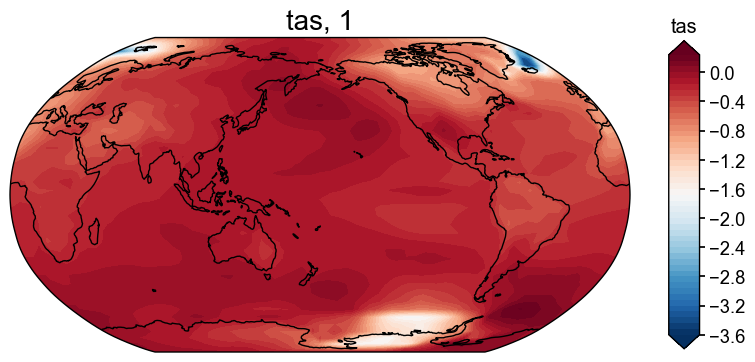

In [31]:
res.load(['tas', 'tas_gm', 'pr', 'pr_gm'])

# Create a basic plot
if 'tas' in res.recons:
    fig, ax = res.recons['tas'].plot()

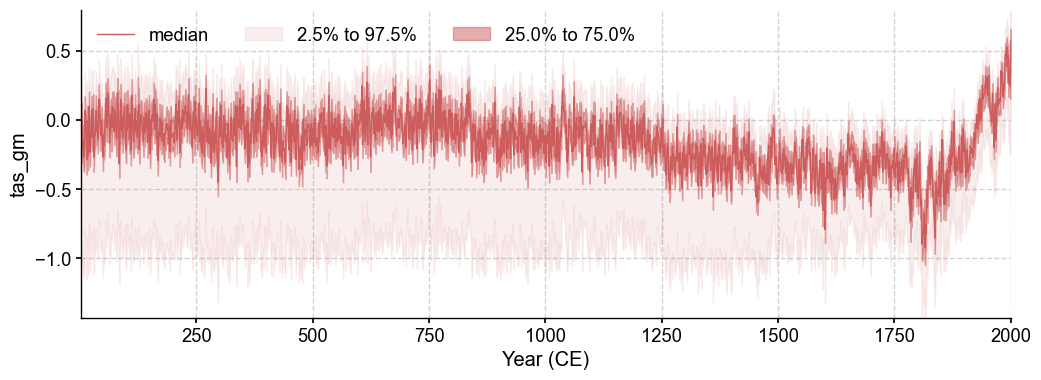

In [29]:
# Plot with ensemble spread
fig, ax = res.recons['tas_gm'].plot_qs()

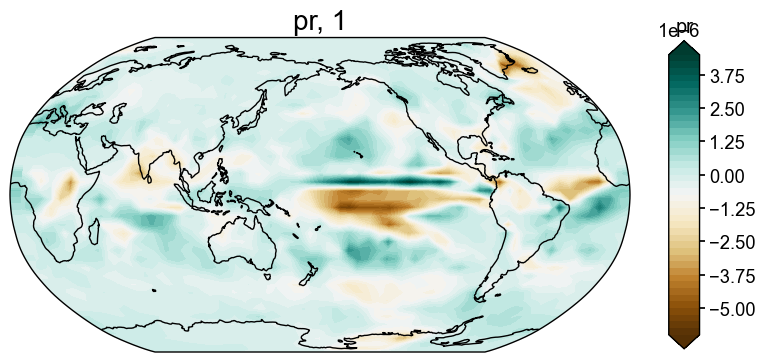

In [27]:
fig, ax = res.recons['pr'].plot()

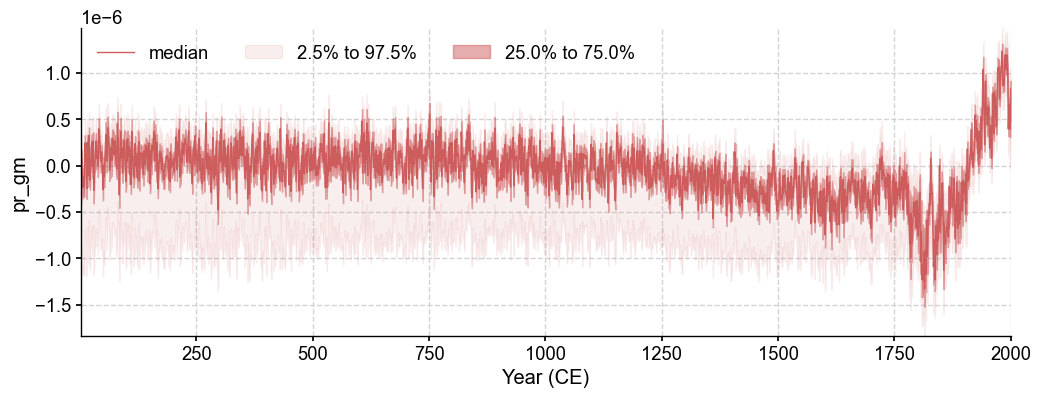

In [32]:
fig, ax = res.recons['pr_gm'].plot_qs()